# Ejercicio 2 - Teoría

---

## 1. ¿Cómo los retrasos en la percepción causan oscilaciones?  
**Analogía del termostato**  
- Un termostato mide la temperatura con un retardo $$\tau$$ entre la medición real y la señal de control.  
- Si la temperatura real es $$T(t)$$, el controlador ve $$T_m(t)=T(t-\tau)$$ y actúa sobre esa lectura retrasada.  
- Con un controlador proporcional simple:  
  $$
  u(t) \;=\; K\bigl(T_{\rm set}-T_m(t)\bigr)
  \;=\;
  K\bigl(T_{\rm set}-T(t-\tau)\bigr)
  $$
- Cuando $$\tau$$ es comparable o mayor que la constante de tiempo del sistema $$\alpha$$, aparece un **desfase de fase** aproximado por $$\phi\approx\omega\,\tau$$ en la respuesta armónica del sistema. Ese desfase puede provocar que la acción de control llegue **demasiado tarde**, generando sobrecorridas y oscilaciones alrededor de la consigna.

---

## 2. ¿Por qué bucles de equilibrio + retrasos → sobreimpulso/insuficiencia?  
1. **Bucle de equilibrio sin retraso**  
   - Con feedback negativo instantáneo, la señal de error se corrige suavemente hasta anularse.  
2. **Inclusión de un retraso $$\tau$$**  
   - La corrección que se aplica en $$t$$ responde al error medido en $$t-\tau$$.  
   - Si el sistema ya ha evolucionado, la acción puede **sobrepasar** el punto de equilibrio.  
3. **Dinámica simplificada**  
   - Para una variable $$x(t)$$ dirigida a cero:  
     $$
     \frac{dx}{dt} \;=\; -a\,x(t-\tau)
     $$
   - La ecuación lineal con retraso tiene soluciones oscilatorias y puede incluso volverse inestable si  
     $$
     a\,\tau > \frac{\pi}{2}\,.
     $$

---

## 3. Ejemplos reales de oscilaciones por retrasos

- **Ciclos económicos**  
  - Bancos centrales ajustan tipos de interés con datos atrasados (PIB, inflación).  
  - Esa señal retrasada lleva a subidas/bajadas que llegan demasiado tarde, provocando **burbujas** o **recesiones**.  

- **Respuestas a pandemias**  
  - Las políticas de confinamiento basadas en datos de casos con retraso (detección, testeo, reporte) suelen **llegar tarde**, permitiendo nuevos brotes antes de actuar.  
  - Después, el levantamiento de medidas puede efectuarse también con retraso, generando un segundo pico.  

---

## 4. Caso práctico

Un sistema con **objetivo** $$O=100$$, **retraso de percepción** $$\tau_p=20\text{ días}$$ y **retraso de ajuste** $$\tau_a=10\text{ días}$$:

### a) Predicción de la magnitud del sobreimpulso  
- Si el controlador aplica toda la corrección $$O$$ de forma uniforme durante $$\tau_a$$ pero mide el error con $$\tau_p$$ de retraso, entonces al iniciar el ajuste el sistema ya ha evolucionado.  
- La fracción de corrección **demasiado tarde** es $$\tau_a/\tau_p$$, por lo que el sobreimpulso estimado es:  
  $$
  \Delta O
  \;=\;
  O \;\times\;\frac{\tau_a}{\tau_p}
  \;=\;
  100 \times \frac{10}{20}
  \;=\;
  50
  $$
> **Resultado:** el proceso sobrepasará el objetivo en **50 unidades** antes de empezar a corregir en sentido inverso.

### b) ¿Cómo reduce las oscilaciones una recopilación de datos más rápida?  
- Disminuir el retraso de percepción $$\tau_p$$ reduce el desfase entre la acción y la verdadera situación.  
- Con $$\tau_p\downarrow$$, la fracción $$\tau_a/\tau_p$$ disminuye, por lo que:  
  $$
  \Delta O
  \;=\;
  O \times \frac{\tau_a}{\tau_p}
  $$
  es menor → **menos sobreimpulso**.  
- En la práctica, sistemas de medición y reporte en **tiempo real** (sensores en continuo, analítica instantánea) permiten ajustar con precisión, amortiguando o eliminando las oscilaciones de la política.  


## Práctica

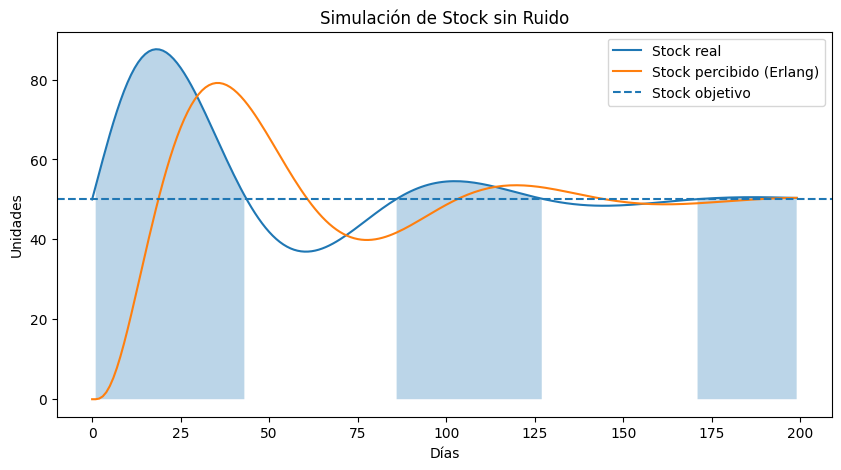

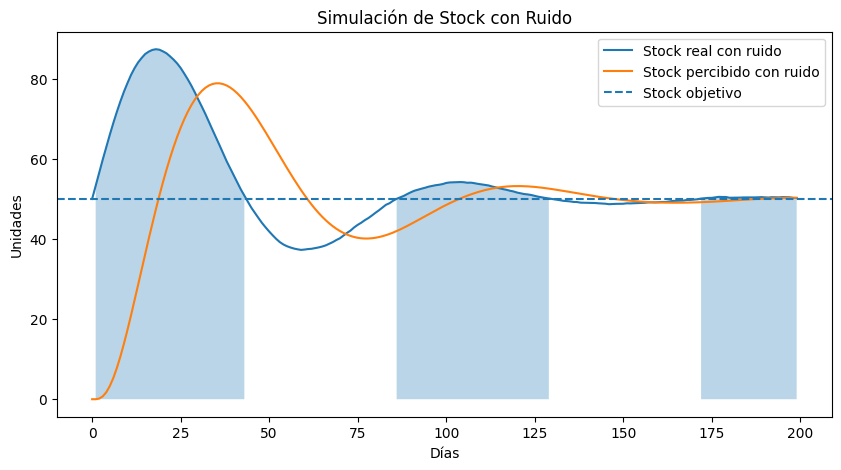

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

# Parámetros de la simulación
days = 200                # Número de días a simular
target = 50.0             # Stock objetivo
delay_days = 15.0         # Retraso medio en días

# Parámetros para el retraso de Erlang (distribución Gamma entera)
shape = 3                 # Parámetro de forma (k)
scale = delay_days / shape  # Parámetro de escala (θ)
kernel_len = 60           # Longitud del kernel de convolución

# Construcción del kernel discreto de Erlang (PDF)
t = np.arange(kernel_len)
kernel = (t ** (shape - 1) * np.exp(-t / scale)) / (math.gamma(shape) * scale ** shape)
kernel /= kernel.sum()  # Normalizar para que sume 1

def simulate(add_noise=False, noise_std=1.0):
    """
    Simula la evolución de un stock real y su percepción con retraso de Erlang.
    
    Parámetros:
    - add_noise (bool): Si True, añade ruido gaussiano a la percepción.
    - noise_std (float): Desviación estándar del ruido.
    
    Retorna:
    - real (ndarray): Stock real día a día.
    - perceived (ndarray): Stock percibido con retraso.
    """
    real = np.zeros(days)
    perceived = np.zeros(days)
    real[0] = target
    
    for i in range(1, days):
        # Ventana para la convolución según cuánto historial haya
        window = min(i, kernel_len)
        # Convolución de stock real con el kernel de Erlang
        perceived[i] = np.dot(real[i - window : i][::-1], kernel[:window])
        
        # Añadir ruido si se solicita
        perceived_i = perceived[i] + (np.random.normal(0, noise_std) if add_noise else 0)
        
        # Cálculo del flujo de ajuste
        flow = (target - perceived_i) / delay_days
        real[i] = real[i - 1] + flow
    
    return real, perceived

# --- Simulación y gráficos ---

# 1) Sin ruido
real_no_noise, perceived_no_noise = simulate(add_noise=False)

plt.figure(figsize=(10, 5))
plt.plot(real_no_noise, label='Stock real')
plt.plot(perceived_no_noise, label='Stock percibido (Erlang)')
plt.axhline(target, linestyle='--', label='Stock objetivo')
# Resaltar fases de sobreimpulso (real > objetivo)
overshoot = real_no_noise > target
plt.fill_between(np.arange(days), 0, real_no_noise, where=overshoot, alpha=0.3)
plt.title('Simulación de Stock sin Ruido')
plt.xlabel('Días')
plt.ylabel('Unidades')
plt.legend()
plt.show()

# 2) Con ruido (ajustable)
real_noise, perceived_noise = simulate(add_noise=True, noise_std=1.0)

plt.figure(figsize=(10, 5))
plt.plot(real_noise, label='Stock real con ruido')
plt.plot(perceived_noise, label='Stock percibido con ruido')
plt.axhline(target, linestyle='--', label='Stock objetivo')
overshoot_noise = real_noise > target
plt.fill_between(np.arange(days), 0, real_noise, where=overshoot_noise, alpha=0.3)
plt.title('Simulación de Stock con Ruido')
plt.xlabel('Días')
plt.ylabel('Unidades')
plt.legend()
plt.show()


# Análisis de las simulaciones de stock

## 1. Comportamiento sin ruido

- **Inicio y ajuste inicial**  
  - El stock real parte en 50 u. y, debido al retraso en la percepción, rápidamente se eleva por encima del objetivo antes de descender.  
  - Este sobreimpulso inicial se debe a que el sistema “ve” un nivel de stock percibido aún bajo, lo que genera un flujo positivo excesivo.

- **Oscilaciones amortiguadas**  
  - Tras el primer pico (~día 25), el stock real cae por debajo del objetivo y luego vuelve a subir.  
  - Las oscilaciones disminuyen en amplitud con el tiempo, acercándose progresivamente a la línea de objetivo (50 u.).

- **Fases de sobrecorrección destacadas**  
  - Se han sombreado en azul claro los tramos donde el stock real supera el objetivo, evidenciando los momentos de sobreimpulso.  
  - Cada fase de exceso es menor que la anterior, mostrando un sistema regresivo hacia el equilibrio.

## 2. Comportamiento con ruido

- **Variabilidad adicional**  
  - Al introducir ruido gaussiano en la percepción, las curvas se vuelven menos suaves, con pequeños picos y valles alrededor de las trayectorias base.  
  - El ruido obliga al controlador a reaccionar a fluctuaciones aparentes, generando ligeras desviaciones del recorrido sin ruido.

- **Resiliencia del sistema**  
  - A pesar de la aleatoriedad, las oscilaciones siguen amortiguándose y el stock real converge cerca del objetivo.  
  - El sistema mantiene su tendencia al equilibrio, aunque la trayectoria hacia él es más tortuosa.

## 3. Papel del retraso de Erlang

- **Perfil del kernel**  
  - El retraso de Erlang introduce un efecto de “memoria distribuida”: la percepción incorpora información de varios días pasados con distinto peso.  
  - Esto suaviza la reacción frente a cambios recientes pero retrasa la corrección, originando oscilaciones.

- **Control proporcional-diferencial implícito**  
  - El flujo calculado como \((objetivo - percibido) / retraso\) actúa como un controlador proporcional con ganancia inversa al retraso.  
  - Cuanto mayor sea el retraso, más lenta y propensa a oscilaciones será la corrección.

## 4. Conclusiones

- **Retraso + retroalimentación = oscilaciones**  
  Las simulaciones confirman que los sistemas con sensores retardados tienden a sobreimpulsos, seguidos de correcciones insuficientes, hasta alcanzar un amortiguamiento natural.
- **Ruido tolerable si el control es robusto**  
  Aunque el ruido añade pequeñas desviaciones, la dinámica de amortiguamiento persiste, señalando que un controlador proporcional sencillo puede ser suficiente en ambientes ruidosos moderados.
- **Ajustes posibles**  
  - **Reducir retraso** → Menos oscilaciones, convergencia más rápida.  
  - **Añadir acción derivativa** → Atacar el sobreimpulso reaccionando a la velocidad de cambio, no solo al error.
- **Aplicaciones reales**  
  Este modelo es útil para entender inventarios con datos demorados (por ejemplo, conteos manuales, sistemas de escaneo batch) y ayudar a diseñar reglas de reabastecimiento más estables.

